# Classification Text LSTM Method

## Import Library 📚

In [696]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import torch
import torch.nn as nn
import torch.optim as optim
import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from torch.nn.utils.rnn import pad_sequence
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, TensorDataset
from imblearn.over_sampling import SMOTE
from wordcloud import WordCloud

## Download required NLTK data 🪡

In [698]:
# Download required NLTK data
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download("vader_lexicon")

[nltk_data] Downloading package wordnet to C:\Users\Aditya P
[nltk_data]     J\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to C:\Users\Aditya P
[nltk_data]     J\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package vader_lexicon to C:\Users\Aditya P
[nltk_data]     J\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

## Read dan preprocess data 👓

In [700]:
# Read the CSV file
data = pd.read_csv(r"C:\Users\Aditya P J\Documents\Matematika\Semester 5\Matkom\scrapped_data.csv")
data = data.dropna()
data.head(10)

,userName,score,at,content
0,Nora Alvatra,4,2024-11-05 04:48:20,bermanfaat
1,Najwa Abel Swastika,2,2024-10-01 10:20:37,Kenapa di punyaku gak ada fitur permohonan sur...
2,Asteen Retno Mukti,5,2024-09-30 08:30:26,Terbaik
3,Mas Widodo,3,2024-09-28 11:05:52,Klu akses sikadu dr aplikasi malah blum bisa ya?
4,Suryana,3,2024-09-17 17:00:40,"Masih banyak bug, terutama kalau mau bikin kar..."
5,Ahmad Muyaqi,4,2024-09-12 01:59:20,"Aplikasi sudah cukup bagus, hanya saja fitur y..."
6,Kazuma Sama,4,2024-09-06 01:06:16,"Fitur² yang sudah cukup bermanfaat, namun perl..."
7,alif tegar,5,2024-09-05 12:00:52,"sudah bagus, mungkin bisa dikembangkan fiturny..."
8,R E Z Q I,1,2024-09-05 08:17:17,eror ga bisa absen
9,Ali Abdul Rozak,5,2024-09-05 05:39:05,Good


In [701]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214 entries, 0 to 213
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   userName  214 non-null    object
 1   score     214 non-null    int64 
 2   at        214 non-null    object
 3   content   214 non-null    object
dtypes: int64(1), object(3)
memory usage: 6.8+ KB


## Clean Data 🗜️

In [703]:
# Text preprocessing
def preprocess_text(text):
    # Convert to lowercase
    text = str(text).lower()
    # Remove symbols, numbers, and emojis
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Remove emojis
    text = text.encode('ascii', 'ignore').decode('ascii')
     # Hapus URL
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Hapus mention dan hashtag
    text = re.sub(r'@\w+|\#\w+', '', text)
    # Hapus punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Hapus angka
    text = re.sub(r'\d+', '', text)
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split()])
    return text

data['content'] = data['content'].apply(preprocess_text)


In [704]:
# Sentiment analysis using VADER
data['content'] = data['content'].apply(preprocess_text)

positive_keywords = ["bagus", "baik", "terbaik", "bermanfaat", "puas", "good", "suka", "mantap", "alhamudulillah", "naiss",
                     "luar biasa", "mengagumkan", "sangat bermanfaat", "memuaskan", "berkualitas tinggi",
                     "hebat", "menyenangkan", "inspiratif", "tak tertandingi", "menakjubkan", "fantastis", "mengesankan",
                     "sempurna", "istimewa", "terpuji", "menginspirasi", "positif", "keren", "memukau", "memesona",
                     "nyaman", "berguna", "maju", "apresiasi", "sangat baik", "terpercaya", "top", "prima", "superb"]

negative_keywords = ["buruk", "repot", "tidak puas", "bug", "masalah", "sayang sekali", "harusnya", "jelek", "lama", "eror", "error", "gabisa",
                     "mengecewakan", "tidak memuaskan", "kurang baik", "tidak profesional", "sangat lambat", "membingungkan", "tidak membantu", "menyebalkan",
                     "tidak berguna", "tidak ramah", "sangat mahal", "kacau", "tidak teratur", "tidak efisien", "tidak sopan", "tidak layak",
                     "menakutkan", "tidak nyaman", "bermasalah", "tidak akurat", "membosankan", "tidak responsif", "berisik", "tidak aman", "merugikan",
                     "mengerikan", "merepotkan", "tidak stabil", "tolong", "bubar", "buruk", "tidak menyenangkan", "close"]

def enhanced_sentiment_analysis(text):
    # Initialize VADER sentiment analyzer
    sid = SentimentIntensityAnalyzer()
    
    # Get VADER scores
    scores = sid.polarity_scores(text)
    
    # Check for keyword presence
    pos_count = sum(1 for word in positive_keywords if word in text.lower())
    neg_count = sum(1 for word in negative_keywords if word in text.lower())
    
    # Combine VADER and keyword analysis
    if pos_count > neg_count and scores['compound'] >= 0:
        return "Positif"
    elif neg_count > pos_count or scores['compound'] < -0.1:
        return "Negatif"
    else:
        return "Netral"

data["LABEL"] = data["content"].apply(enhanced_sentiment_analysis)

# Print distribution
print("Distribution of sentiments:")
print(data["LABEL"].value_counts())

Distribution of sentiments:
LABEL
Netral     117
Positif     50
Negatif     47
Name: count, dtype: int64


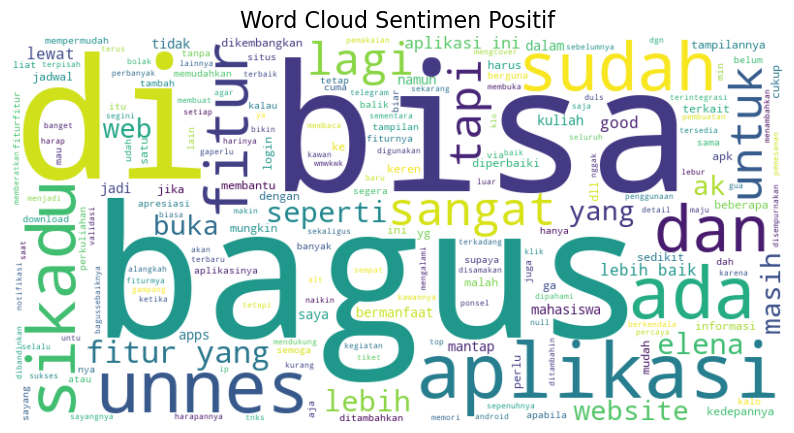

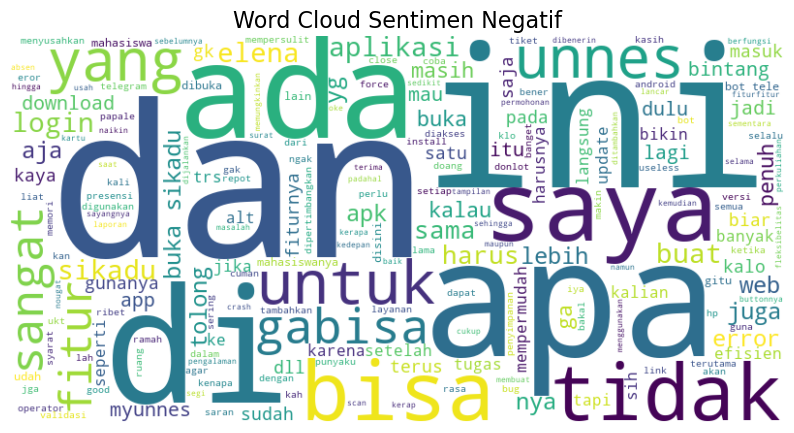

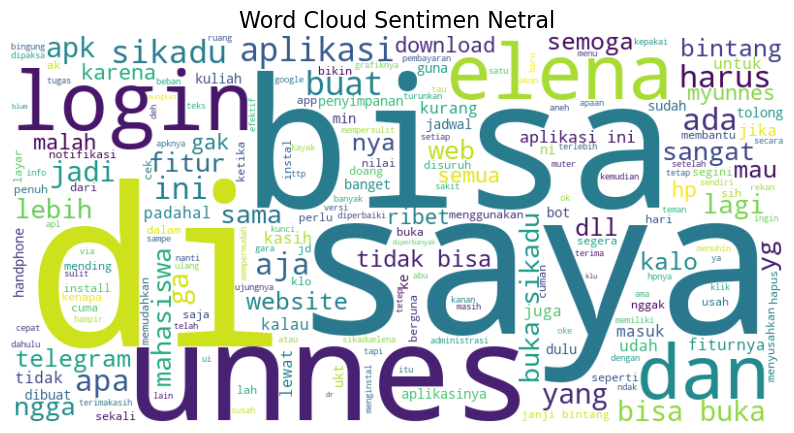

In [705]:
# Word Cloud function
def generate_word_cloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(' '.join(text))
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title, fontsize=16)
    plt.axis('off')
    plt.show()

# Filter data based on sentiment labels
positive_texts = data[data['LABEL'] == 'Positif']['content']
negative_texts = data[data['LABEL'] == 'Negatif']['content']
neutral_texts = data[data['LABEL'] == 'Netral']['content']

# Generate Word Clouds for positive and negative sentiment texts
generate_word_cloud(positive_texts, "Word Cloud Sentimen Positif")
generate_word_cloud(negative_texts, "Word Cloud Sentimen Negatif")
generate_word_cloud(neutral_texts, "Word Cloud Sentimen Netral")

In [706]:
# Tokenization
MAX_WORDS = 5000
MAX_LENGTH = 100

tokenizer = Tokenizer(num_words=MAX_WORDS)
tokenizer.fit_on_texts(data['content'])
X = tokenizer.texts_to_sequences(data['content'])
X = pad_sequences(X, maxlen=MAX_LENGTH)

# Encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(data["LABEL"])

In [707]:
#Split data
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# Apply SMOTE for oversampling (only on training data)
smote = SMOTE(random_state=42)
X_train_reshaped = X_train.reshape(X_train.shape[0], -1)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_reshaped, y_train)
X_train_resampled = X_train_resampled.reshape(-1, MAX_LENGTH)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train_resampled, dtype=torch.long)
y_train = torch.tensor(y_train_resampled, dtype=torch.long)
X_val = torch.tensor(X_val, dtype=torch.long)
y_val = torch.tensor(y_val, dtype=torch.long)
X_test = torch.tensor(X_test, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

# Create DataLoaders
train_data = TensorDataset(X_train, y_train)
val_data = TensorDataset(X_val, y_val)
test_data = TensorDataset(X_test, y_test)

BATCH_SIZE = 32
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE)


## Membangun Arsitektur LSTM

In [709]:
#LSTM model
class ImprovedLSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           bidirectional=True, 
                           dropout=dropout if n_layers > 1 else 0,
                           batch_first=True)
        self.fc1 = nn.Linear(hidden_dim * 2, hidden_dim)
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
        
    def forward(self, text):
        embedded = self.dropout(self.embedding(text))
        output, (hidden, cell) = self.lstm(embedded)
        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
        dense1 = self.fc1(hidden)
        drop = self.dropout(dense1)
        relu = self.relu(drop)
        output = self.fc2(relu)
        return output


In [710]:
# Model parameters
VOCAB_SIZE = min(len(tokenizer.word_index) + 1, MAX_WORDS)
EMBEDDING_DIM = 400
HIDDEN_DIM = 64
OUTPUT_DIM = len(label_encoder.classes_)
N_LAYERS = 2
DROPOUT = 0.

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize model
model = ImprovedLSTMClassifier(
    vocab_size=VOCAB_SIZE,
    embedding_dim=EMBEDDING_DIM,
    hidden_dim=HIDDEN_DIM,
    output_dim=OUTPUT_DIM,
    n_layers=N_LAYERS,
    dropout=DROPOUT
)

model = model.to(device)

# Loss function
class_counts = np.bincount(y_train_resampled)
class_weights = torch.FloatTensor(1.0 / class_counts).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

# Early stopping setup
class EarlyStopping:
    def __init__(self, patience=3):
        self.patience = patience
        self.counter = 0
        self.best_loss = float('inf')

    def check(self, val_loss):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0
            return False
        else:
            self.counter += 1
            if self.counter >= self.patience:
                return True
            return False

early_stopper = EarlyStopping(patience=3)

In [711]:
# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs):
    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0
        for batch in train_loader:
            x, y = [t.to(device) for t in batch]
            optimizer.zero_grad()
            output = model(x)
            loss = criterion(output, y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)  # Aggressive gradient clipping
            optimizer.step()
            train_loss += loss.item()
        
        # Validation
        model.eval()
        val_loss = 0
        val_preds = []
        val_labels = []
        with torch.no_grad():
            for batch in val_loader:
                x, y = [t.to(device) for t in batch]
                output = model(x)
                loss = criterion(output, y)
                val_loss += loss.item()
                pred = output.argmax(dim=1)
                val_preds.extend(pred.cpu().numpy())
                val_labels.extend(y.cpu().numpy())
        
        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        print(f'Epoch: {epoch+1} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}')
        print(classification_report(val_labels, val_preds, target_names=label_encoder.classes_))
        scheduler.step(val_loss)
        
        if early_stopper.check(val_loss):  # Check early stopping
            print("Early stopping triggered.")
            break
        
        # Save best model
        if val_loss == early_stopper.best_loss:
            torch.save(model.state_dict(), 'best_model_small_data.pt')

In [712]:
# Train the model
EPOCHS = 20
train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, EPOCHS)

# Test model
model.load_state_dict(torch.load('best_model_small_data.pt'))
model.eval()
test_preds = []
test_labels = []

with torch.no_grad():
    for batch in test_loader:
        x, y = [t.to(device) for t in batch]
        output = model(x)
        pred = output.argmax(dim=1)
        test_preds.extend(pred.cpu().numpy())
        test_labels.extend(y.cpu().numpy())

print("\nTest Set Results:")
print(classification_report(test_labels, test_preds, target_names=label_encoder.classes_))

Epoch: 1 | Train Loss: 1.1053 | Val Loss: 1.1057
              precision    recall  f1-score   support

     Negatif       0.00      0.00      0.00         7
      Netral       0.00      0.00      0.00        18
     Positif       0.22      1.00      0.36         7

    accuracy                           0.22        32
   macro avg       0.07      0.33      0.12        32
weighted avg       0.05      0.22      0.08        32



D:\Terminal\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\Terminal\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\Terminal\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\Terminal\Lib\site-packages\torch\optim\lr_scheduler.py:240: UserWarning: The

Epoch: 2 | Train Loss: 1.0830 | Val Loss: 1.1058
              precision    recall  f1-score   support

     Negatif       0.00      0.00      0.00         7
      Netral       0.00      0.00      0.00        18
     Positif       0.22      1.00      0.36         7

    accuracy                           0.22        32
   macro avg       0.07      0.33      0.12        32
weighted avg       0.05      0.22      0.08        32



D:\Terminal\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\Terminal\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\Terminal\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\Terminal\Lib\site-packages\torch\optim\lr_scheduler.py:240: UserWarning: The

Epoch: 3 | Train Loss: 1.0498 | Val Loss: 1.0997
              precision    recall  f1-score   support

     Negatif       0.00      0.00      0.00         7
      Netral       0.00      0.00      0.00        18
     Positif       0.23      1.00      0.37         7

    accuracy                           0.22        32
   macro avg       0.08      0.33      0.12        32
weighted avg       0.05      0.22      0.08        32



D:\Terminal\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\Terminal\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\Terminal\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\Terminal\Lib\site-packages\torch\optim\lr_scheduler.py:240: UserWarning: The

Epoch: 4 | Train Loss: 0.9557 | Val Loss: 1.0680
              precision    recall  f1-score   support

     Negatif       0.80      0.57      0.67         7
      Netral       0.67      0.22      0.33        18
     Positif       0.33      1.00      0.50         7

    accuracy                           0.47        32
   macro avg       0.60      0.60      0.50        32
weighted avg       0.62      0.47      0.44        32



D:\Terminal\Lib\site-packages\torch\optim\lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 5 | Train Loss: 0.7247 | Val Loss: 1.0013
              precision    recall  f1-score   support

     Negatif       0.67      0.57      0.62         7
      Netral       0.50      0.33      0.40        18
     Positif       0.29      0.57      0.38         7

    accuracy                           0.44        32
   macro avg       0.48      0.49      0.47        32
weighted avg       0.49      0.44      0.44        32



D:\Terminal\Lib\site-packages\torch\optim\lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 6 | Train Loss: 0.3192 | Val Loss: 1.0427
              precision    recall  f1-score   support

     Negatif       0.80      0.57      0.67         7
      Netral       0.57      0.44      0.50        18
     Positif       0.31      0.57      0.40         7

    accuracy                           0.50        32
   macro avg       0.56      0.53      0.52        32
weighted avg       0.56      0.50      0.51        32



D:\Terminal\Lib\site-packages\torch\optim\lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 7 | Train Loss: 0.0868 | Val Loss: 1.6153
              precision    recall  f1-score   support

     Negatif       0.67      0.57      0.62         7
      Netral       0.55      0.33      0.41        18
     Positif       0.33      0.71      0.45         7

    accuracy                           0.47        32
   macro avg       0.52      0.54      0.49        32
weighted avg       0.53      0.47      0.47        32



D:\Terminal\Lib\site-packages\torch\optim\lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 8 | Train Loss: 0.0244 | Val Loss: 1.3817
              precision    recall  f1-score   support

     Negatif       0.67      0.57      0.62         7
      Netral       0.65      0.61      0.63        18
     Positif       0.44      0.57      0.50         7

    accuracy                           0.59        32
   macro avg       0.59      0.58      0.58        32
weighted avg       0.61      0.59      0.60        32

Early stopping triggered.

Test Set Results:
              precision    recall  f1-score   support

     Negatif       0.33      0.29      0.31         7
      Netral       0.58      0.39      0.47        18
     Positif       0.33      0.62      0.43         8

    accuracy                           0.42        33
   macro avg       0.42      0.43      0.40        33
weighted avg       0.47      0.42      0.43        33



D:\Terminal\Lib\site-packages\torch\optim\lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
C:\Users\Aditya P J\AppData\Local\Temp\ipykernel_24620\2217537589.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for 


Test Set Evaluation:
              precision    recall  f1-score   support

     Negatif       0.33      0.29      0.31         7
      Netral       0.58      0.39      0.47        18
     Positif       0.33      0.62      0.43         8

    accuracy                           0.42        33
   macro avg       0.42      0.43      0.40        33
weighted avg       0.47      0.42      0.43        33

Akurasi Keseluruhan: 0.4242


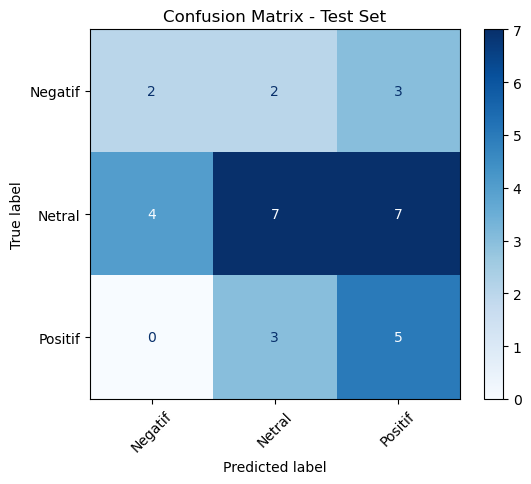

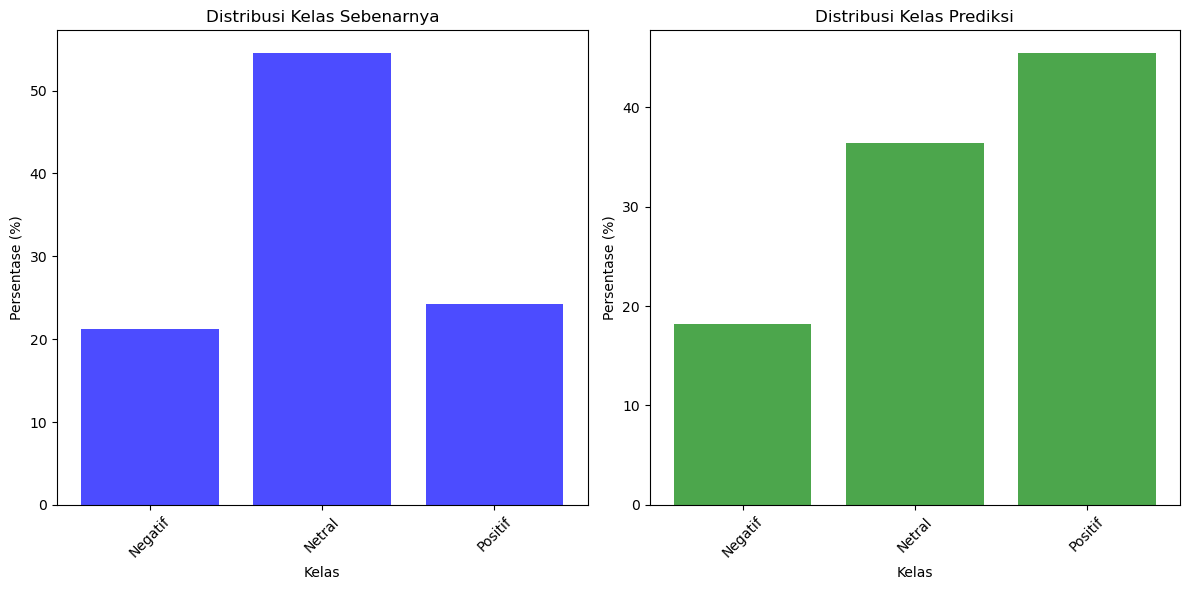

In [713]:
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay

# Evaluasi pada data uji
print("\nTest Set Evaluation:")

# Laporan klasifikasi
print(classification_report(test_labels, test_preds, target_names=label_encoder.classes_))

# Akurasi keseluruhan
test_accuracy = accuracy_score(test_labels, test_preds)
print(f"Akurasi Keseluruhan: {test_accuracy:.4f}")

# Matriks Kebingungan
cm = confusion_matrix(test_labels, test_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix - Test Set")
plt.show()

# Visualisasi Distribusi Kelas Prediksi vs Sebenarnya
plt.figure(figsize=(12, 6))

# Histogram label sebenarnya (persentase)
plt.subplot(1, 2, 1)
unique, counts = np.unique(test_labels, return_counts=True)
percentages = (counts / len(test_labels)) * 100
plt.bar(unique, percentages, color='blue', alpha=0.7)
plt.xticks(ticks=np.arange(len(label_encoder.classes_)), labels=label_encoder.classes_, rotation=45)
plt.title("Distribusi Kelas Sebenarnya")
plt.xlabel("Kelas")
plt.ylabel("Persentase (%)")

# Histogram prediksi (persentase)
plt.subplot(1, 2, 2)
unique_preds, counts_preds = np.unique(test_preds, return_counts=True)
percentages_preds = (counts_preds / len(test_preds)) * 100
plt.bar(unique_preds, percentages_preds, color='green', alpha=0.7)
plt.xticks(ticks=np.arange(len(label_encoder.classes_)), labels=label_encoder.classes_, rotation=45)
plt.title("Distribusi Kelas Prediksi")
plt.xlabel("Kelas")
plt.ylabel("Persentase (%)")

plt.tight_layout()
plt.show()


In [714]:
# Save model state
torch.save(model.state_dict(), 'lstm_sentiment_model.pth')
print("Model saved successfully!")


Model saved successfully!


In [715]:
# Load model state
model.load_state_dict(torch.load('lstm_sentiment_model.pth'))
model.eval()
print("Model loaded successfully!")


Model loaded successfully!


C:\Users\Aditya P J\AppData\Local\Temp\ipykernel_24620\1092315473.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('lstm_sentiment_model.